# Languages used on Wikipedia, by country and over time

## Imports and definitions

In [152]:
import json
import requests
from datetime import date
import pandas as pd
import pygal
from IPython.display import SVG
import pprint
import geopandas as gpd
import country_converter as coco

# Important: update pygal's map: https://github.com/Kozea/pygal_maps_world/pull/5

# Function used below to display maps
def display_svg(svg_code):
     return SVG(svg_code)

pp = pprint.PrettyPrinter(indent=4)

# As specified there: https://wikimedia.org/api/rest_v1/#/
# Without your contact details you'll get an error
contact_details = 'a455bcd9 on Wikipedia / @ADssx on Twitter'
headers = {
    'User-Agent': contact_details
}

# Get all projects from the Wikimedia Foundation
projects_list_url = 'https://commons.wikimedia.org/w/api.php?action=sitematrix&smtype=language&format=json'
projects_list_json = requests.get(projects_list_url, headers=headers).text

projects = json.loads(projects_list_json)

## List of all Wikipedias

In [131]:
wiki_codes = []
id = 0

# Look the whole list
for i in projects['sitematrix']:
    # Only fetch dictionnaries
    if isinstance(projects['sitematrix'][i],dict):
        # Get the language code
        code = projects['sitematrix'][i]['code']
        
        # Avoid issue with classical orthography Belarusian Wikipedia
        if code == 'be-x-old':
            continue

        # For each language, look at all different projects
        for j in projects['sitematrix'][i]['site']:
            # If the project is a Wikipedia, add the language code to the list of Wikipedias
            if j['code'] == 'wiki':
                wiki_codes += [code]

# For testing purposes
test_mode = False
if test_mode:
    # Set to have unique languade codes in case there's a mistake in the list
    wiki_codes = set(['en', 'ja', 'es', 'de', 'ru', 'fr', 'it', 'zh', 'pt', 'pl', 'tr', 'ko', 'ar', 'arz', 'nl', 'he', 'fa', 'id'])
    # wiki_codes = ['fr', 'de']

print('Analysis of', len(wiki_codes), 'Wikipedias')

Analysis of 316 Wikipedias


## Month to analyze

In [3]:
analyze_last_month = True
if analyze_last_month:
    # By default, use the last month
    today = date.today()

    year = today.year
    month = today.month - 1

    # Special case for January
    if today.month == 1:
        year = year - 1
        month = 12

    last_month = date(year, month, 1)
else:
    # Pick any other month
    last_month = date(2019, 5, 1)

# Convert to string to add to URL
point_in_time = last_month.strftime('%Y/%m')

print('Analyzed period:', point_in_time)

Analyzed period: 2021/01


## Pageviews by country

In [4]:
# For each Wikipedia, get the number of page views in the analyzed month, by country

# API example: https://wikimedia.org/api/rest_v1/metrics/pageviews/top-by-country/fr.wikipedia/all-access/2021/01
base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/top-by-country/'

all_wikipedias = pd.DataFrame(columns=['country'])

for code in wiki_codes:
    # For each Wikipedia get the list of page views by country
    project = code + '.wikipedia'

    countries_url = base_url + project + '/all-access/' + point_in_time

    countries_json = requests.get(countries_url, headers=headers).text

    countries = json.loads(countries_json)
    
    # Transform to a dataframe
    df = pd.DataFrame.from_dict(countries['items'][0]['countries'])

    # Drop useless columns
    df = df.drop(columns=['views', 'rank'])

    # Rename one column
    df = df.rename(columns={'views_ceil': code})

    # Merging the dataframes on the country key with outer join
    all_wikipedias = pd.merge(all_wikipedias, df, how='outer', on='country')
    
# Set the country code as index
all_wikipedias = all_wikipedias.set_index('country')

## Most popular Wikipedias in a given country

In [5]:
country_code = 'GB'
popular_wikipedias_in_country = all_wikipedias.loc[country_code].sort_values(ascending=False)[0:10]
print('\nMost popular Wikipedias in', country_code, ':')
print(popular_wikipedias_in_country)

# Same but in %
print('\nMost popular Wikipedias in', country_code, ', %:')
print((100. * popular_wikipedias_in_country / popular_wikipedias_in_country.sum()).round(1))

# Get the most popular Wikipedia by country
most_popular_by_country = all_wikipedias.idxmax(axis=1)

# Add back the index
most_popular_by_country = most_popular_by_country.reset_index()

# Rename the column
most_popular_by_country = most_popular_by_country.rename(columns={0: 'most_popular'})

# Number of countries where each edition is top
popular_wikipedias = most_popular_by_country.groupby(['most_popular']).count()
# Sort by number of countries where language is first
popular_wikipedias = popular_wikipedias.sort_values(by=['country'], ascending=False)

# Languages that are number one in at least one country
top_languages = set(most_popular_by_country['most_popular'])
print('\n', len(top_languages), 'languages are first in at least one country or territory:')
print(top_languages)

# Names of countries where each edition arrives first
# We concatenate country codes
# https://stackoverflow.com/a/22221675/5285608
countries_by_language = most_popular_by_country.groupby('most_popular')['country'].apply(list).to_dict()


Most popular Wikipedias in GB :
en    998607000.0
zh      5552000.0
pl      4719000.0
fr      4339000.0
ru      3886000.0
it      3794000.0
fa      3673000.0
de      3025000.0
es      3017000.0
ja      2098000.0
Name: GB, dtype: float64

Most popular Wikipedias in GB , %:
en    96.7
zh     0.5
pl     0.5
fr     0.4
ru     0.4
it     0.4
fa     0.4
de     0.3
es     0.3
ja     0.2
Name: GB, dtype: float64

 34 languages are first in at least one country or territory:
{'hy', 'cs', 'vi', 'ja', 'he', 'ko', 'zh', 'ar', 'de', 'it', 'fr', 'tr', 'sv', 'pl', 'es', 'el', 'ru', 'fa', 'az', 'lv', 'hu', 'th', 'nl', 'pt', 'sr', 'fi', 'ro', 'sk', 'lt', 'ka', 'id', 'bg', 'en', 'no'}


## SVG map of popular languages

8 languages #1 in at least 4 countries


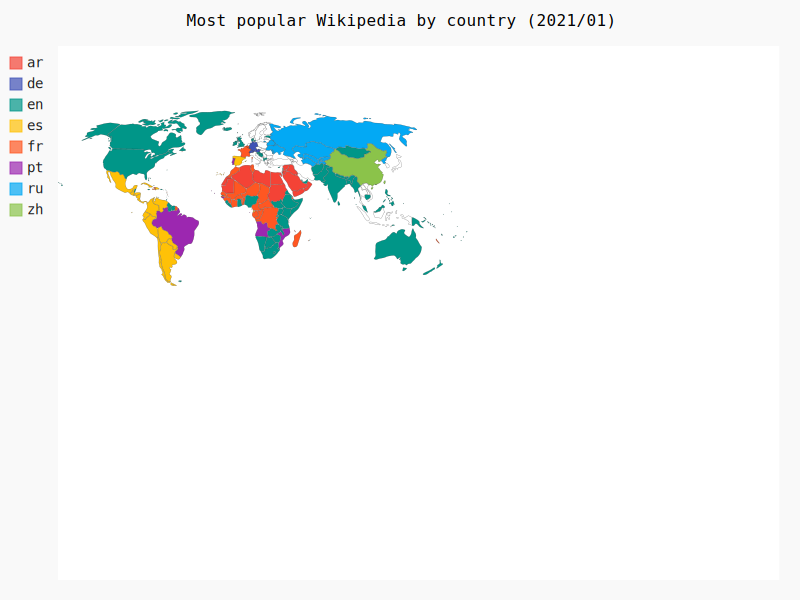

In [6]:
worldmap_chart = pygal.maps.world.World()
worldmap_chart.title = 'Most popular Wikipedia by country (' + point_in_time + ')'

c = 0
for language in countries_by_language:
    # Threshold to appear on the map
    map_threshold = 3
    if len(countries_by_language[language]) > map_threshold:
        # Increase the count
        c += 1
        # Add countries and languages to the map
        worldmap_chart.add(language, [x.lower() for x in countries_by_language[language]])

print(c, 'languages #1 in at least', map_threshold + 1, 'countries')

# Save in a file
# javascript should be removed to allow upload on Wikimedia, maybe with add_scripts()?
# In the meantime, remove manually after export
worldmap_chart.render_to_file('chart.svg')

# Display in the notebook
svg_code = worldmap_chart.render()
display_svg(svg_code)

## PNG alternative of the map

-99 not found in ISOnumeric


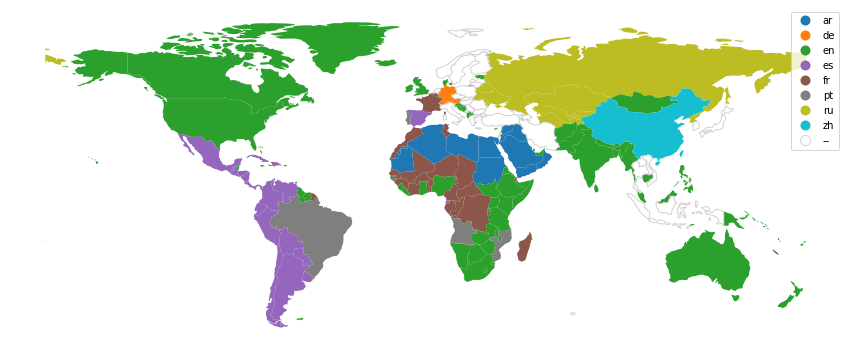

In [207]:
# Dataframe with countries and geoloc
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Add missing iso3
# https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3

# Metropolitan France should have a different code from overseas territories
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
# Norway should have a different code from SJM
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
# Somaliland is recognized as a part of Somalia and doesn't have its own code
world.loc[world.name == 'Somaliland', 'iso_a3'] = 'SOM'
# Northern Cyprus is recognized as a part of Cyprus and doesn't have its own code
world.loc[world.name == 'N. Cyprus', 'iso_a3'] = 'CYP'

# Converting to ISO 3166-1 alpha-2 
world['iso_a2'] = coco.convert(names=world['iso_a3'].tolist(), to='ISO2')

# Kosovo doesn't have an iso3 code but an unofficial iso2 code
# https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2
world.loc[world.name == 'Kosovo', 'iso_a2'] = 'XK'

# New empty column for the most read language
world['language'] = None

# Loop over the languages and countries to add them to the map
for language in countries_by_language:
    # Threshold to appear on the map
    map_threshold = 3
    if len(countries_by_language[language]) > map_threshold:
        # Increase the count
        # Update language for these countries
        for x in countries_by_language[language]:
            world.loc[world.iso_a2 == x, 'language'] = language

# Specify the style and label of features containing None or NaN
params = {
    'column': 'language',
    'figsize': (15, 10),
    'legend': True,
    'missing_kwds': {
        'color': 'white',
        'edgecolor': 'lightgrey',
        'label': '--',
    },
}

# Do not display Antarctica
world[world.name != 'Antarctica'].plot(**params).set_axis_off()

# To have customs colors (such as 'green for ar'):
# https://towardsdatascience.com/create-categorical-choropleth-with-python-122da5ae6764
# https://github.com/geopandas/geopandas/issues/1269

## For each language: world map with color scale based on its use

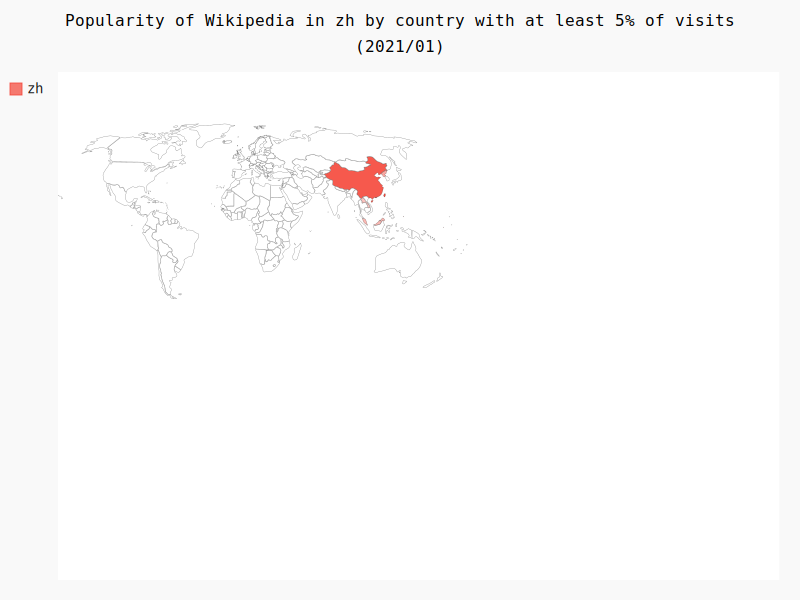

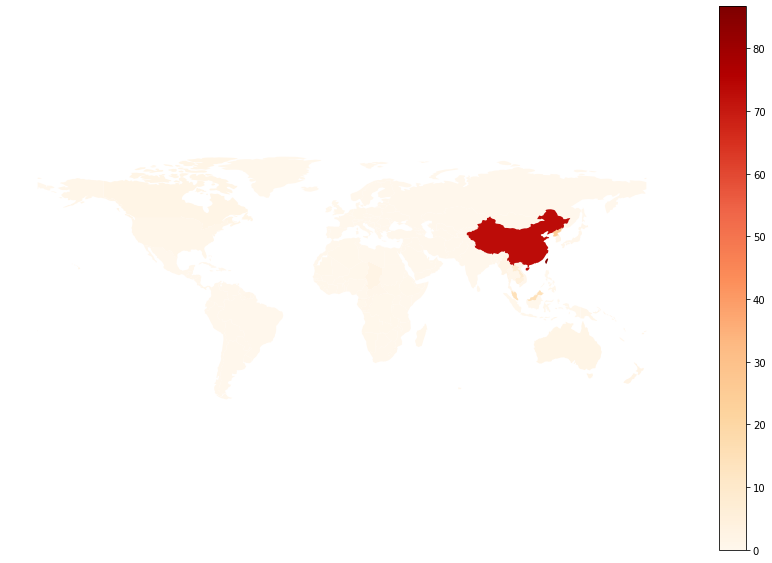

In [84]:
# Percentage instead of absolute numbers
# https://stackoverflow.com/a/42006745/5285608
all_wikipedias_relative = all_wikipedias[all_wikipedias.columns].div(all_wikipedias[all_wikipedias.columns].sum(axis=1), axis=0).multiply(100)

# Language to display
language_code = 'zh'

worldmap_chart = pygal.maps.world.World()
# Threshold in percentage
threshold = 5
worldmap_chart.title = 'Popularity of Wikipedia in ' + language_code + ' by country with at least ' + str(threshold) + '% of visits (' + point_in_time + ')'

language_relative = all_wikipedias_relative[language_code].to_dict()

# Country codes to lowercase & filtering based on threshold
language_relative_filtered = {key.lower(): value for key, value in language_relative.items() if value > threshold}

# Countries where this language is the most viewed, descending order
if pd.DataFrame.from_dict(language_relative_filtered, orient='index').empty is False:
    # print(pd.DataFrame.from_dict(language_relative_filtered, orient='index').sort_values(by=0, ascending=False))

    # Add to the map
    worldmap_chart.add(language_code, language_relative_filtered)

    # Display in the notebook
    svg_code = worldmap_chart.render()
else:
     print('No country with', language_code, 'above the selected threshold')


# Try another lib
world[language_code] = 0

for key, value in language_relative.items():
    world.loc[world.iso_a2 == key, language_code] = value

params = {
    'column': language_code,
    'figsize': (15, 10),
    'legend': True,
    'cmap': 'OrRd',
    # Wistia
    #'missing_kwds': {
    #    'color': 'white',
    #    'edgecolor': 'lightgrey',
    #    'label': '--',
    #},
}
    
world[world.name != 'Antarctica'].plot(**params).set_axis_off();

display_svg(svg_code)

## For a given language: simplied world map to display countries where it is ranked at least nth

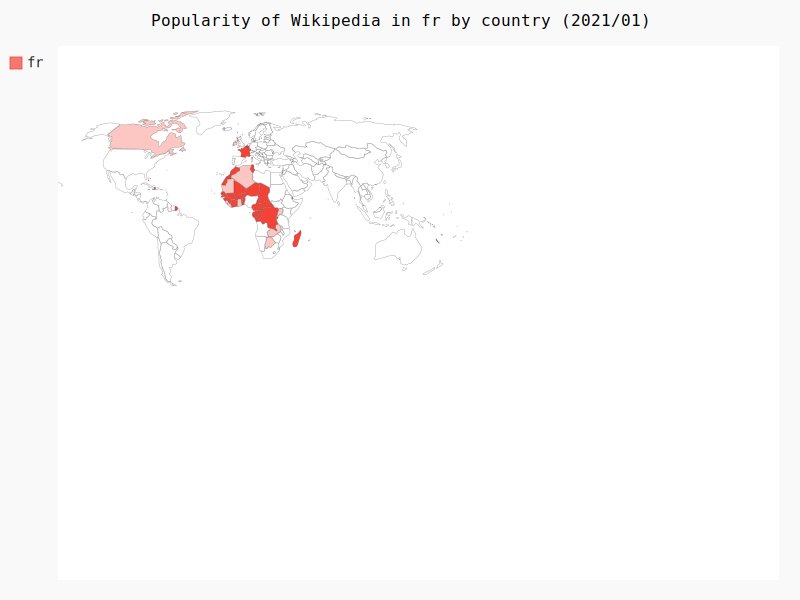

In [30]:
# Language to display
language_code = 'fr'

worldmap_chart = pygal.maps.world.World()

worldmap_chart.title = 'Popularity of Wikipedia in ' + language_code + ' by country (' + point_in_time + ')'

# Rank languages by pageviews in each country
all_wikipedias_ranked = all_wikipedias.rank(axis=1, method='min', ascending=False)
language_ranked = all_wikipedias_ranked[language_code].to_dict()

# We display only countries where rank >= threshold
threshold = 2

# Country codes to lowercase & filtering based on threshold &
# invert ranking for correct gradien display in pygal
language_ranked = {key.lower(): (abs(value - threshold)) for key, value in language_ranked.items() if value <= threshold}

# Add to the map
worldmap_chart.add(language_code, language_ranked)

# Save to file
save = False
if save:
    filename = language_code + '_rank_' + point_in_time.replace('/', '_') + '_chart.svg'
    worldmap_chart.render_to_file(filename)

# Display in the notebook
svg_code = worldmap_chart.render()
display_svg(svg_code)

## Evolution of popular languages over time

In [ ]:
# API example:
# https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikipedia.org/all-access/user/monthly/20210101/20210201
base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/'

index = 'timestamp'
all_languages_pageviews = pd.DataFrame(columns=[index])

start_date = '20101101'
end_date = date.today().strftime('%Y%m%d')
date_range = start_date + '/' + end_date

for code in wiki_codes:
    # For each Wikipedia get the list of page views by country
    project = code + '.wikipedia.org'

    pageviews_url = base_url + project + '/all-access/user/monthly/' + date_range

    pageviews_json = requests.get(pageviews_url, headers=headers).text

    pageviews = json.loads(pageviews_json)

    # Transform to a dataframe
    df = pd.DataFrame.from_dict(pageviews['items'])
    
    # Drop useless columns
    df = df.drop(columns=['project', 'access', 'agent', 'granularity'])
    
    # Rename one column
    df = df.rename(columns={'views': code})
    
    # Merging the dataframes on the country key with outer join
    all_languages_pageviews = pd.merge(all_languages_pageviews, df, how='outer', on=index)

# Set index
all_languages_pageviews = all_languages_pageviews.set_index(index)

# Divide each row by the sum of the row to get %
all_languages_pageviews_pct = all_languages_pageviews.divide(all_languages_pageviews.sum(axis=1), axis=0)

20101101/20210207


The English Wikipedia represents 48% of page views on all Wikipedias


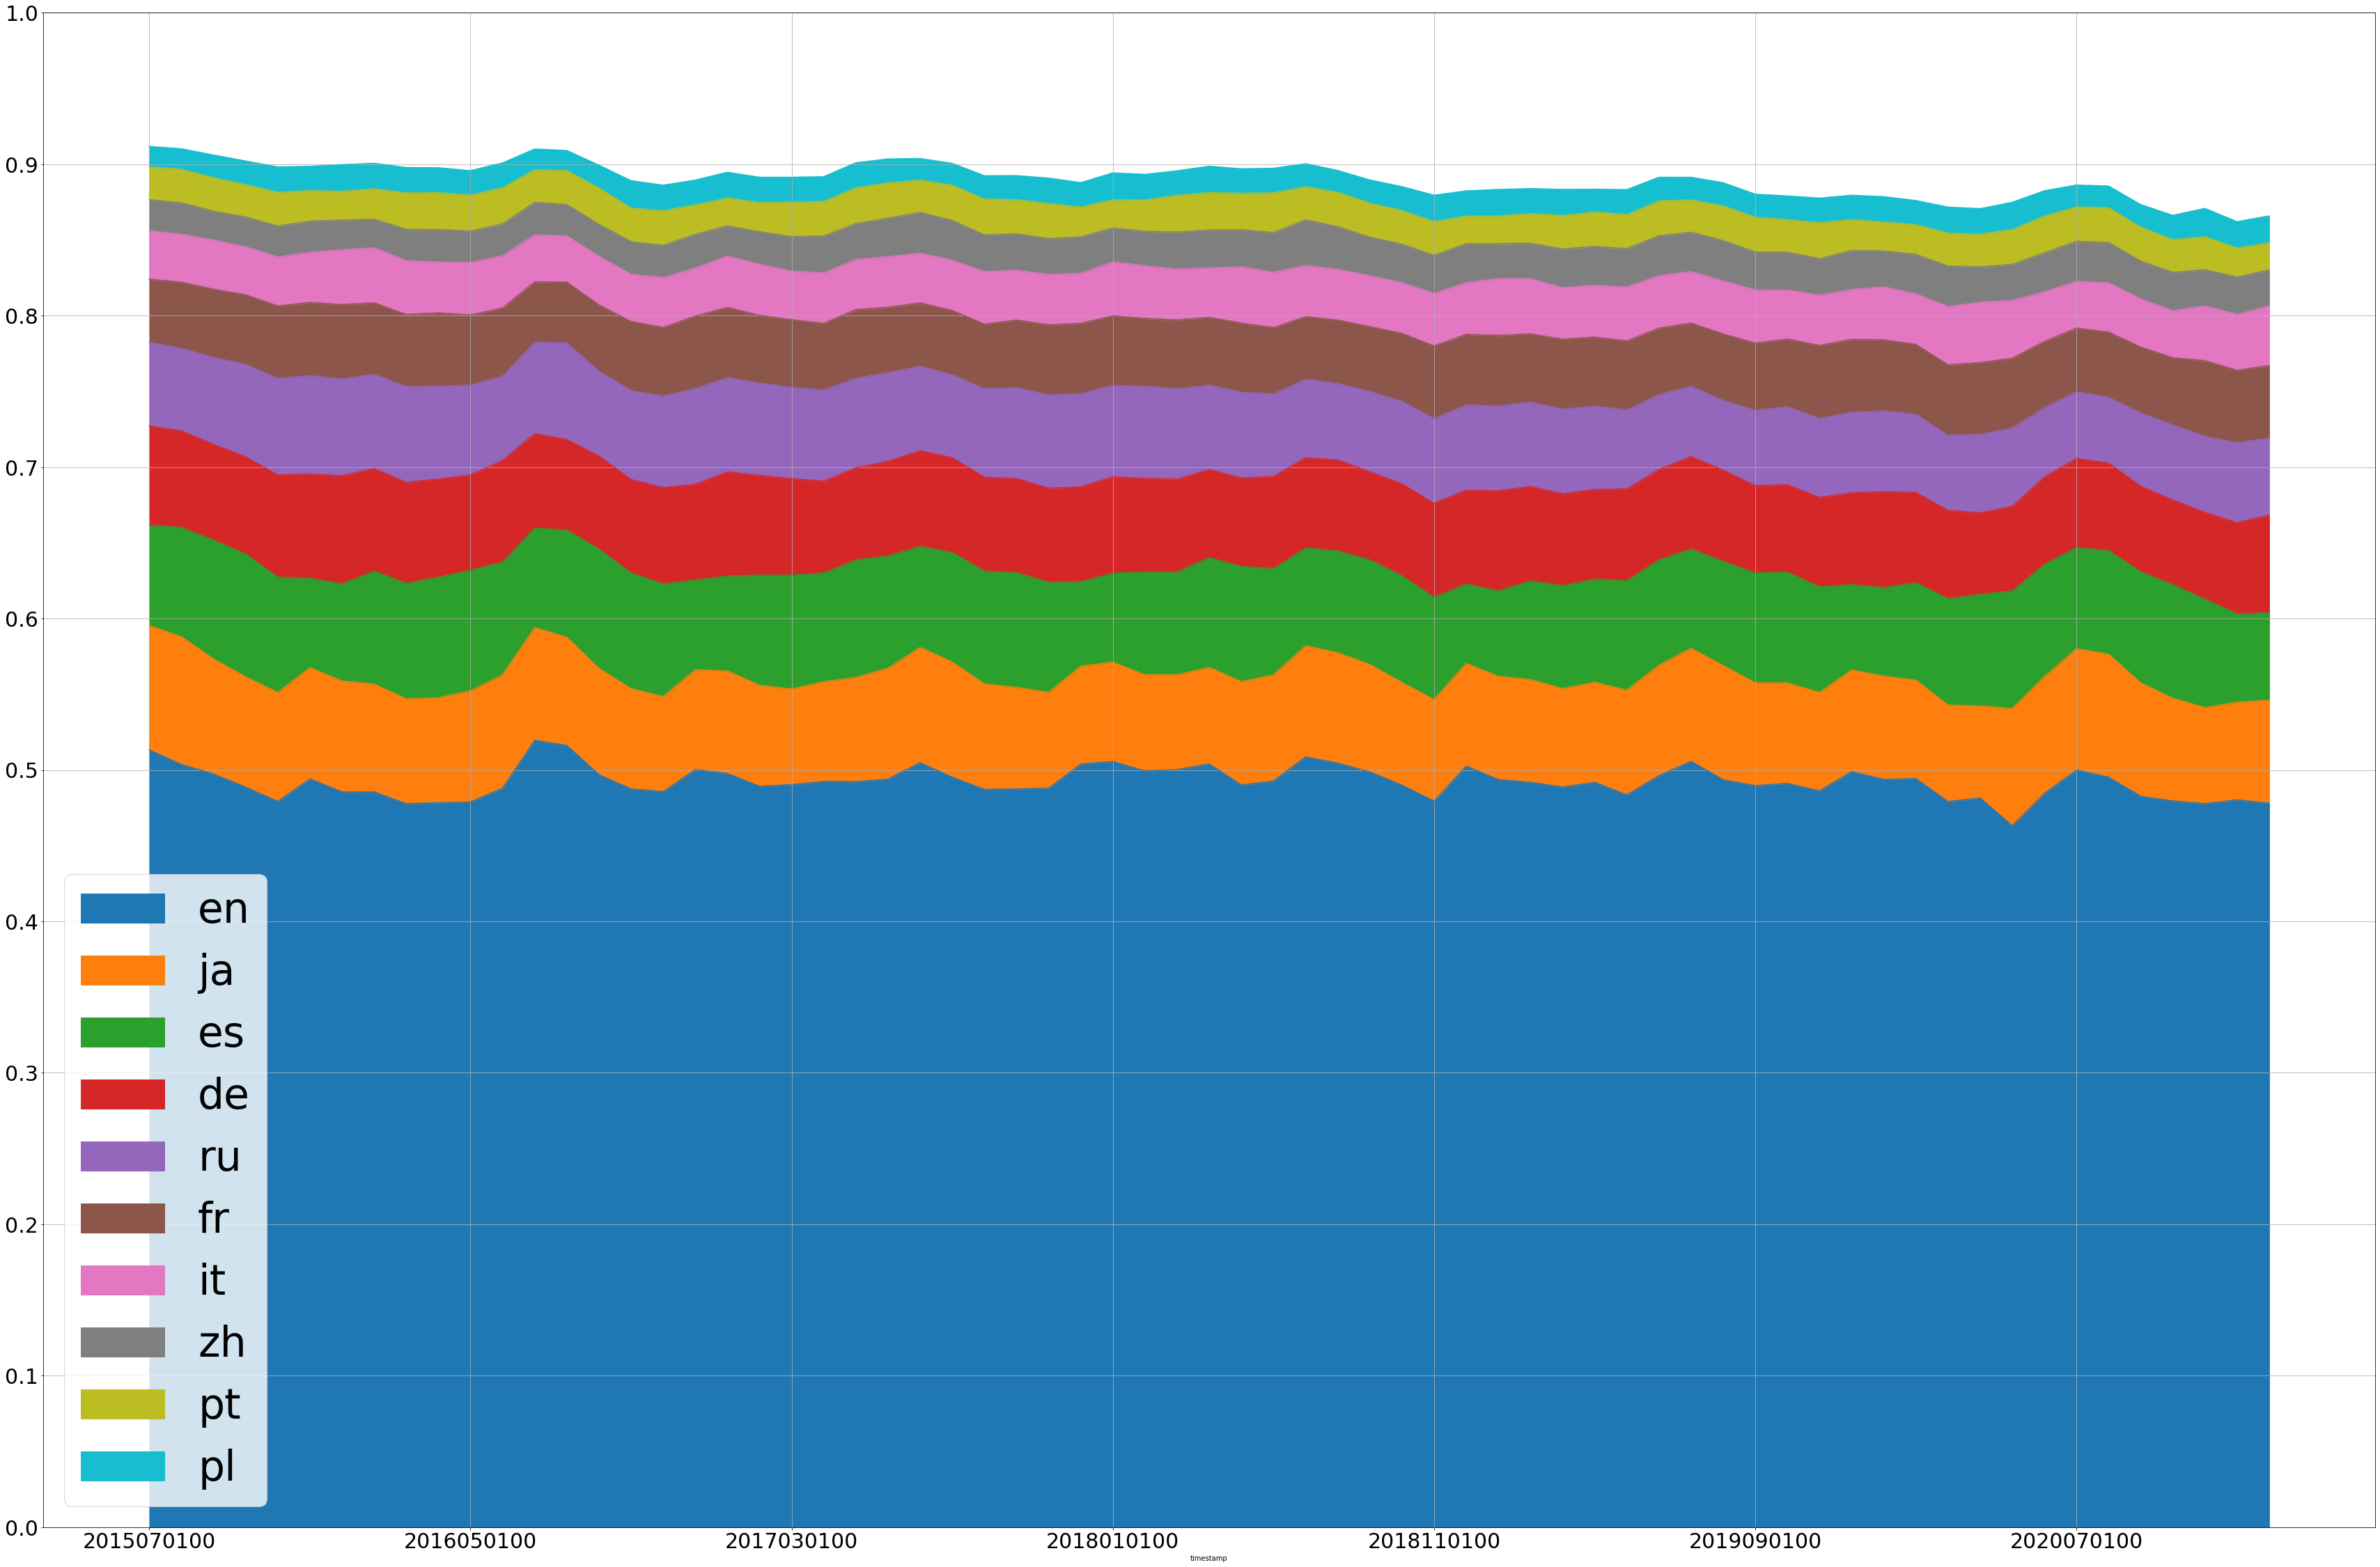

In [206]:
# Only display the most viewed
# https://meta.wikimedia.org/wiki/List_of_Wikipedias/Table2
most_viewed_wp = ['en', 'ja', 'es', 'de', 'ru', 'fr', 'it', 'zh', 'pt', 'pl']

print('The English Wikipedia represents {:.0f}% of page views on all Wikipedias'.format(100 * all_languages_pageviews_pct.iloc[[-1]]['en'][0]))

params = {
    'y': most_viewed_wp,
    'figsize': (60,40),
    'fontsize': 30,
    'yticks': [x/10 for x in range(11)],
    'grid': True,
    'legend': False,
}
ax = all_languages_pageviews_pct.plot.area(**params)
leg = ax.legend(loc=3, prop={'size': 60})